# Chapter 2

In [1]:
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch as T

from scm import SCM, CategoricalDistribution, get_probability_table

print(sys.version)

3.11.2 (main, Mar 27 2023, 18:39:42) [Clang 14.0.6 ]



# Definition 2.1.1 -- Structural Causal Model (SCM).

A structural causal model $\mathcal M$ is a 4-tuple $\langle \mathbf U, \mathbf V, \mathcal F, P(\mathbf U)$, where

- $\mathbf U$ is a set of background variables, also called exogenous variables, that are determined by factors outside the model;
- $\mathbf V$ is a set $\{V_1, \dots V_n\}$ of variables, called endogenous, that are determined by other variables in the model — that is, variables in $\mathbf U \cup \mathbf V$.
- $\mathcal F$ is a set of functions $\{f_1, \dots f_n\}$ such that each $f_i$ is a mapping from (the respective domains of) $U_i \cup \mathbf{Pa}_i$ to $V_i$, where $U_i \in \mathbf U, \mathbf{Pa}_i \in \mathbf V \setminus V_i$, and the entire set $\mathcal F$ forms a mapping from $\mathbf U$ to $\mathbf V$. That is, for $i = 1, \dots, n$, each $f_i \in \mathcal F$ is such that

$$v_i \gets f_i(\mathbf{pa}_i, \mathbf{u}_i)$$

i.e., it assigns to a value to $V_i$ that depends on (the values of) a select set of variables in $\mathbf U \cup \mathbf V$; and

- $P(\mathbf U)$ is a probability function defined over the domain of $\mathbf U$.

## Example 2.1
Consider a game of chance described through the SCM $\mathcal M^1 = \langle \mathbf U = \{U_1, U_2\}, \mathbf V = \{X, Y\}, \mathcal F, P(U_1, U_2)\rangle$, where

$$\mathcal F = \begin{cases}
X &\gets U_1 + U_2 \\
Y &\gets U_1 - U_2
\end{cases}$$

and $P(U_i = k) = 1/6$; $i = 1,2$; $k = 1, \dots, 6$.

In [8]:
m1 = SCM(
    f=dict(
        x=lambda v, u: u['u1'] + u['u2'],
        y=lambda v, u: u['u1'] - u['u2'],
    ),
    pu=CategoricalDistribution(p=dict(
        u1=T.ones(6) / 6,
        u2=T.ones(6) / 6
    )),
)

v = m1.sample(n=10**6)

First, we plot an empirical histogram of each variable's using $10^6$ samples drawn from its distribution.

Text(0.5, 1.0, 'y')

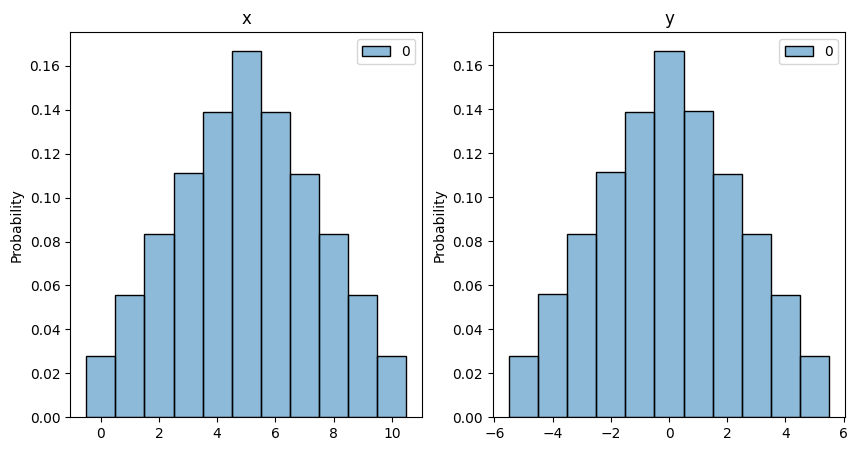

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(v['x'], label='x', ax=axes[0], discrete=True, stat="probability")
axes[0].set_title('x')   
sns.histplot(v['y'], label='y', ax=axes[1], discrete=True, stat="probability")
axes[1].set_title('y')   

Then, we compute the joint distribution of $X, Y$ in closed form, given that all variables are discrete.

In [10]:
get_probability_table(m1)

,x,y,probability
0,0,0,0.027778
1,1,-1,0.027778
2,1,1,0.027778
3,2,-2,0.027778
4,2,0,0.027778
5,2,2,0.027778
6,3,-3,0.027778
7,3,-1,0.027778
8,3,1,0.027778
9,3,3,0.027778


Text(0.5, 1.0, 'Joint distribution of x and y')

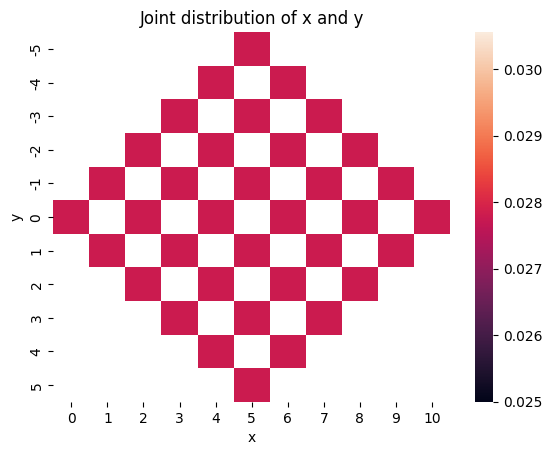

In [11]:
sns.heatmap(pd.pivot(get_probability_table(m1), index='y', columns='x', values='probability'))
plt.title('Joint distribution of x and y')

# Example 2.2

Consider the SCM

$$
\mathcal M^2 = \begin{cases}
    \mathbf V &= \{X, Y, Z\}\\
    \mathbf U &= \{U_r, U_x, U_y, U_z\}\\
    \mathcal F &= \begin{cases}
        Z := \mathbf 1[U_r = 1, U_z = 1]\\
        X := \mathbf 1[Z = 1, U_x = 1] + \mathbf 1[Z = 0, U_x = 0]\\
        Y := \mathbf 1[X = 1, U_r = 1] + \mathbf 1[X = 0, U_r = 1, U_y = 1] + \mathbf 1[X = 0, U_r = 0, U_y = 0]\\
    \end{cases}\\
    P(\mathbf U) &= \begin{cases}
       U_r &\sim \mathrm{Bern}(0.25) \\
       U_z &\sim \mathrm{Bern}(0.95) \\
       U_x &\sim \mathrm{Bern}(0.9) \\
       U_y &\sim \mathrm{Bern}(0.7) \\
    \end{cases}
\end{cases}
$$


In [12]:
m2 = SCM(
    f={
        'z': lambda v, u: ((u['r'] == 1) & (u['z'] == 1)).long(),
        'x': lambda v, u: ((v['z'] == 1) & (u['x'] == 1)).long() + ((v['z'] == 0) & (u['x'] == 0)).long(),
        'y': lambda v, u: (
            ((v['x'] == 1) & (u['r'] == 1)).long()
            + ((v['x'] == 0) & (u['r'] == 1) & (u['y'] == 1)).long()
            + ((v['x'] == 0) & (u['r'] == 0) & (u['y'] == 0)).long()
        ),
    },
    pu=CategoricalDistribution(p=dict(
        r=0.25,
        z=0.95,
        x=0.9,
        y=0.7,
    ))
)

In [16]:
get_probability_table(m2)

,z,x,y,probability
0,0,0,0,0.475875
1,0,0,1,0.210375
2,0,1,0,0.075000
3,0,1,1,0.001250
4,1,0,0,0.007125
5,1,0,1,0.016625
6,1,1,1,0.213750
